In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
! pip install folium
import folium
from sklearn.cluster import KMeans

     |████████████████████████████████| 92kB 7.0MB/s eta 0:00:011


In [2]:
df=pd.read_csv('https://data.melbourne.vic.gov.au/resource/vtsx-jhki.csv')
df.head()

,year,geography,total_population,total_0_4_years,total_5_9_years,total_10_14_years,total_15_19_years,total_20_24_years,total_25_29_years,total_30_34_years,...,female_40_44_years,female_45_49_years,female_50_54_years,female_55_59_years,female_60_64_years,female_65_69_years,female_70_74_years,female_75_79_years,female_80_84_years,female_85_years_and_over
0,2016,City of Melbourne,146096,4902,2688,2018,11593,31755,28314,19085,...,3139,2723,2571,2337,2076,1790,1128,738,534,815
1,2017,City of Melbourne,159141,5253,2914,2415,12391,34538,31403,20652,...,3408,3012,2742,2477,2269,1859,1273,808,558,863
2,2018,City of Melbourne,169961,5739,3159,2668,13046,36091,33750,22232,...,3686,3178,2939,2668,2401,1968,1445,854,592,893
3,2019,City of Melbourne,179814,6101,3422,2879,14464,37723,35128,23471,...,3916,3399,3076,2832,2521,2083,1561,941,621,922
4,2020,City of Melbourne,190238,6452,3672,3053,15539,39417,36820,24920,...,4255,3605,3240,3001,2653,2220,1687,1029,687,957


Combine age groups to gather 
a. First home buyers (25-34) against
f. Retirees (65+)
Sum up 
Use Foursquare data to find out which suburb is already well developed and where new developments would be best placed.
General: Find least developed most popluar suburb

In [3]:
df = df[df.columns.drop(list(df.filter(regex='female')))]
df = df[df.columns.drop(list(df.filter(regex='male')))]
df.head()

,year,geography,total_population,total_0_4_years,total_5_9_years,total_10_14_years,total_15_19_years,total_20_24_years,total_25_29_years,total_30_34_years,...,total_40_44_years,total_45_49_years,total_50_54_years,total_55_59_years,total_60_64_years,total_65_69_years,total_70_74_years,total_75_79_years,total_80_84_years,total_85_years_and_over
0,2016,City of Melbourne,146096,4902,2688,2018,11593,31755,28314,19085,...,6639,5474,5071,4594,4046,3580,2366,1492,977,1294
1,2017,City of Melbourne,159141,5253,2914,2415,12391,34538,31403,20652,...,7192,5961,5387,4901,4371,3672,2668,1620,1032,1380
2,2018,City of Melbourne,169961,5739,3159,2668,13046,36091,33750,22232,...,7763,6325,5755,5264,4619,3883,2947,1725,1096,1446
3,2019,City of Melbourne,179814,6101,3422,2879,14464,37723,35128,23471,...,8265,6700,6021,5603,4837,4082,3157,1888,1175,1496
4,2020,City of Melbourne,190238,6452,3672,3053,15539,39417,36820,24920,...,8935,7084,6405,5908,5084,4332,3346,2074,1289,1566


In [4]:
df_pi= df.pivot(index='year', columns='geography', values='total_population')
df_pi= df_pi.drop(columns=['City of Melbourne'])
df_pi.head()

geography,Carlton,Docklands,East Melbourne,Kensington,Melbourne (CBD),Melbourne (Remainder),North Melbourne,Parkville,Port Melbourne,South Yarra,Southbank,West Melbourne (Industrial),West Melbourne (Residential)
year,,,,,,,,,,,,,
2016,20245,11832,5475,11605,40181,1760,16197,7898,10,4700,20280,103,5809
2017,21573,14873,5581,11701,44722,2325,16763,8106,10,4815,21890,101,6680
2018,21988,16639,5694,11801,48549,2701,17399,8299,10,4881,24008,98,7892
2019,24361,17470,5811,11935,52366,2680,18100,8930,10,4846,24801,96,8410
2020,25481,18478,6157,11919,55750,2676,19631,8955,10,4848,27010,95,9227


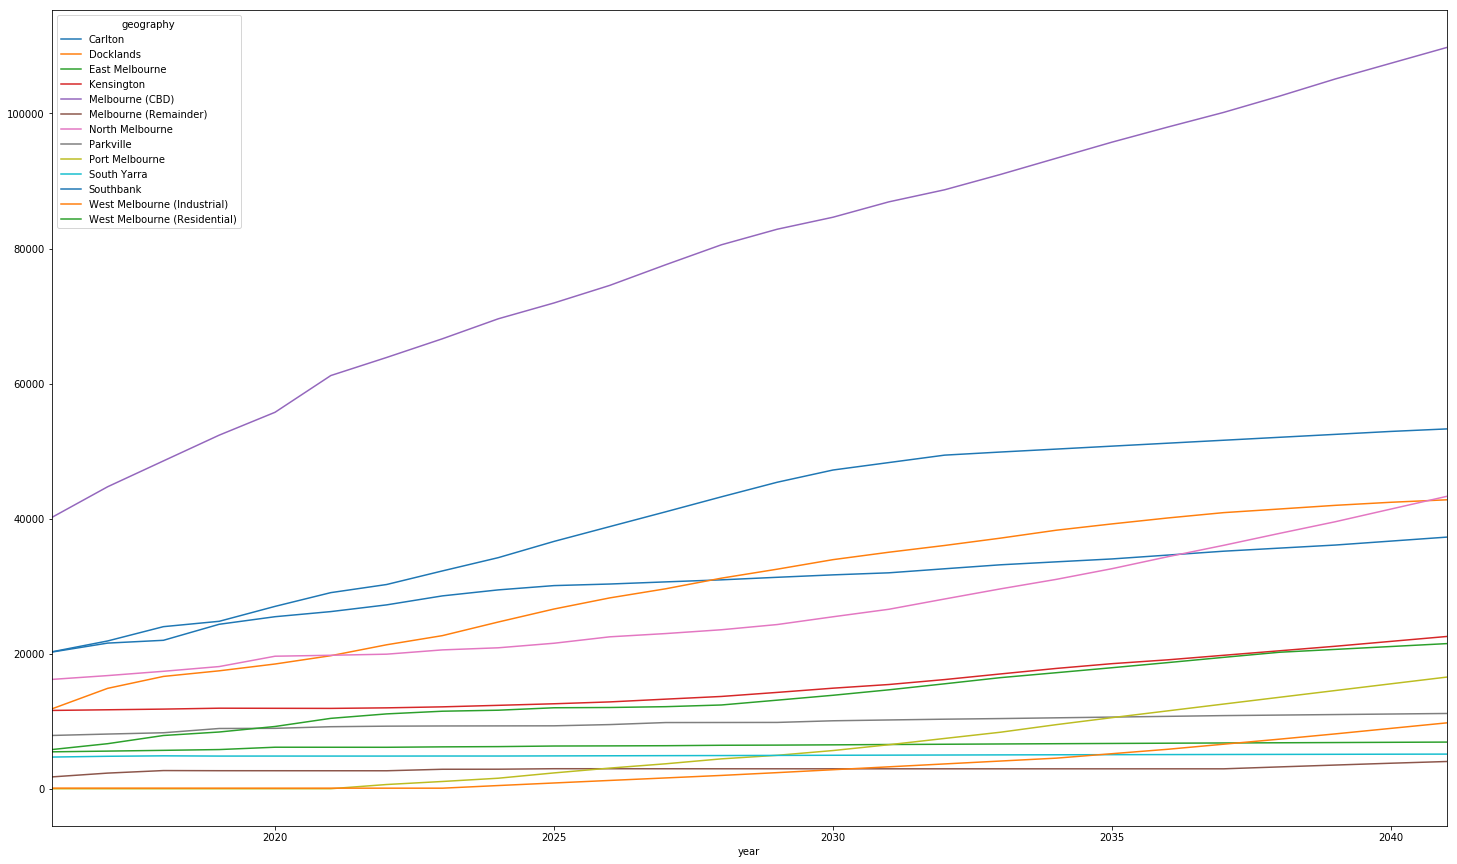

In [5]:
df_pi.plot(figsize=(25,15))

In [6]:
#Get Latitude and Longitude for suburbs
address= df['geography'].apply(lambda x: x.split('-')[-1]+', VIC, Australia').unique()
geolocater= Nominatim(user_agent="melbourne-coordinates")
location=[]
empty=[]

def getcoords(suburb):
    try:
        coord= geolocater.geocode(suburb, timeout=10)
        location.append([suburb, coord.latitude, coord.longitude])
        print("Coordinates of {}".format(location[-1]))
    
    except GeocoderTimedOut:
        return getcoords(suburb)
    
    except:
        empty.append([suburb])
        print("Couldn't find coordinates of {}".format(empty[-1]))
        
for suburb in address:
        getcoords(suburb)

Coordinates of ['City of Melbourne, VIC, Australia', -37.8142176, 144.9631608]
Coordinates of ['Carlton, VIC, Australia', -37.8004228, 144.9684343]
Coordinates of ['Docklands, VIC, Australia', -37.8175423, 144.9394923]
Coordinates of ['East Melbourne, VIC, Australia', -37.812498, 144.9858851]
Coordinates of ['Kensington, VIC, Australia', -37.7939378, 144.9305645]
Coordinates of ['Melbourne (CBD), VIC, Australia', -37.8141823, 144.9598007]
Couldn't find coordinates of ['Melbourne (Remainder), VIC, Australia']
Coordinates of ['North Melbourne, VIC, Australia', -37.8076092, 144.9423514]
Coordinates of ['Parkville, VIC, Australia', -37.7871148, 144.9515533]
Coordinates of ['Port Melbourne, VIC, Australia', -37.8333613, 144.9219203]
Coordinates of ['South Yarra, VIC, Australia', -37.8377695, 144.9918537]
Coordinates of ['Southbank, VIC, Australia', -37.8253618, 144.9640203]
Couldn't find coordinates of ['West Melbourne (Industrial), VIC, Australia']
Coordinates of ['West Melbourne (Resident

In [7]:
#Produce new dataframe showing location, latitude and longitude and save in a csv
df_coord = pd.DataFrame(location, columns=['Area','Latitude','Longitude'])
df_coord = df_coord.drop(0)
df_coord.reset_index(drop=True, inplace=True)
df_coord.to_csv('suburb_coord.csv')
df_coord

,Area,Latitude,Longitude
0,"Carlton, VIC, Australia",-37.800423,144.968434
1,"Docklands, VIC, Australia",-37.817542,144.939492
2,"East Melbourne, VIC, Australia",-37.812498,144.985885
3,"Kensington, VIC, Australia",-37.793938,144.930565
4,"Melbourne (CBD), VIC, Australia",-37.814182,144.959801
5,"North Melbourne, VIC, Australia",-37.807609,144.942351
6,"Parkville, VIC, Australia",-37.787115,144.951553
7,"Port Melbourne, VIC, Australia",-37.833361,144.921920
8,"South Yarra, VIC, Australia",-37.837770,144.991854
9,"Southbank, VIC, Australia",-37.825362,144.964020


In [44]:
#create a map of Melbourne
area = df_coord.iloc[4]['Area']
lat_cc = df_coord.iloc[4]['Latitude']
lon_cc = df_coord.iloc[4]['Longitude']
print('The geograpical coordinate of {} are {}, {}.'.format(area, lat, lon))

The geograpical coordinate of Melbourne (CBD), VIC, Australia are -37.81044755, 144.92042979350134.


In [45]:
map_vic = folium.Map(location=[lat_cc,lon_cc],zoom_start=13)
for lat, lon, area in zip(df_coord['Latitude'], df_coord['Longitude'],df_coord['Area']):
    label=folium.Popup(area, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=0,
        parse_html=False).add_to(map_vic)
    
map_vic

In [10]:
CLIENT_ID = '4VALZY552R5SIBD5MV5UFX1WDFAYAZFOTKONZSM1RBF2X1AJ' # your Foursquare ID
CLIENT_SECRET = '35FFI2RTET4X4TEOML50L3T1ZBRHZBES40DC3YJXA5QIRRCY' # your Foursquare Secret
VERSION = '20200214' # Date

#gwtting high level categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

len(results['response']['categories'])

10

In [11]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


In [12]:
def get_venues_count(lat,lon, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                lon,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

#Create new dataframe to store venues data
df_mel = df_coord.copy()
for c in categories_list:
    df_mel[c[0]] = 0
    
df_mel.head()

,Area,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Carlton, VIC, Australia",-37.800423,144.968434,0,0,0,0,0,0,0,0,0,0
1,"Docklands, VIC, Australia",-37.817542,144.939492,0,0,0,0,0,0,0,0,0,0
2,"East Melbourne, VIC, Australia",-37.812498,144.985885,0,0,0,0,0,0,0,0,0,0
3,"Kensington, VIC, Australia",-37.793938,144.930565,0,0,0,0,0,0,0,0,0,0
4,"Melbourne (CBD), VIC, Australia",-37.814182,144.959801,0,0,0,0,0,0,0,0,0,0


In [13]:
#Request number of venues, store result as CSV
for i, row in df_mel.iterrows():
    for c in categories_list:        
        df_mel.loc[i, c[0]] = get_venues_count(df_mel.Latitude.iloc[i], df_mel.Longitude.iloc[i], radius=1000, categoryId=c[1])
    print(i)
    df_mel.to_csv('area_mel.csv')

import pandas as pd
df_mel=pd.read_csv('area_mel.csv', index_col=0)
df_mel.head()

0
1
2
3
4
5
6
7
8
9
10


,Area,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Carlton, VIC, Australia",-37.800423,144.968434,17,101,8,169,64,44,42,22,53,54
1,"Docklands, VIC, Australia",-37.817542,144.939492,7,5,5,89,17,25,62,12,35,31
2,"East Melbourne, VIC, Australia",-37.812498,144.985885,7,8,2,106,50,27,44,3,43,43
3,"Kensington, VIC, Australia",-37.793938,144.930565,2,3,1,51,7,9,20,0,14,9
4,"Melbourne (CBD), VIC, Australia",-37.814182,144.959801,64,80,8,250,149,76,152,54,186,171


In [14]:
from sklearn.preprocessing import MinMaxScaler

X = df_mel.values[:,3:]
scaled_data = MinMaxScaler().fit_transform(X)

df_mel_scaled = pd.DataFrame(scaled_data)
df_mel_scaled.columns = [c[0] for c in categories_list]
df_mel_scaled.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.253968,1.000000,1.000,0.674699,0.429530,0.561644,0.256757,0.407407,0.281081,0.299401
1,0.095238,0.049505,0.625,0.353414,0.114094,0.301370,0.391892,0.222222,0.183784,0.161677
2,0.095238,0.079208,0.250,0.421687,0.335570,0.328767,0.270270,0.055556,0.227027,0.233533
3,0.015873,0.029703,0.125,0.200803,0.046980,0.082192,0.108108,0.000000,0.070270,0.029940
4,1.000000,0.792079,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


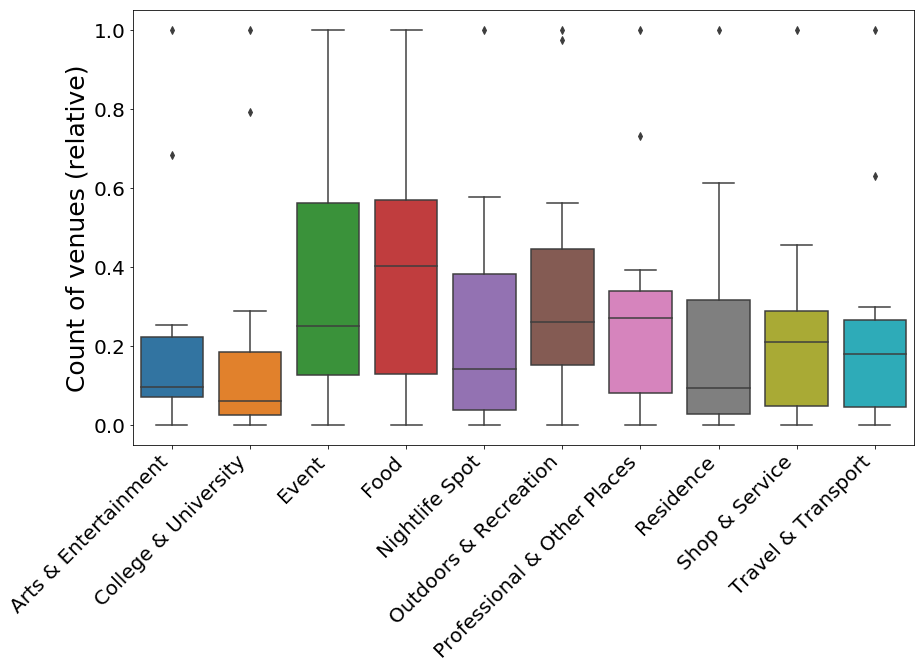

In [15]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_mel_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [16]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_mel_scaled)

kmeans_labels = kmeans.labels_

df_mel_clu = df_mel.copy()
df_mel_clu['Cluster'] = kmeans_labels

#dataframe to be used for box plot
df_scaled_clustered = df_mel_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

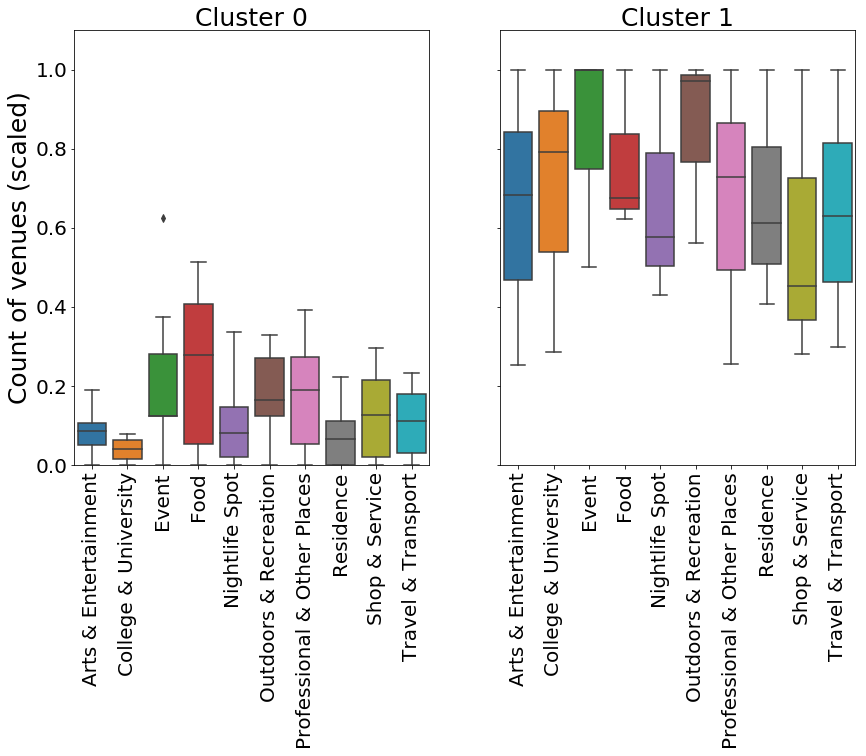

In [18]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (scaled)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [81]:
map_melbourne_gma = folium.Map(location=[lat_cc,lon_cc],zoom_start=13)

#add markers
for i, area, lat, lon, cluster in zip(df_mel_clu.index,
                                         df_mel_clu['Area'],
                                         df_mel_clu['Latitude'],
                                         df_mel_clu['Longitude'],
                                         df_mel_clu['Cluster']):   
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['red','black']
    folium.CircleMarker(
        [lat,lon],
        fill=True,
        fill_opacity=0,
        popup=folium.Popup(area, parse_html=True),
        radius=8,
        color=colors[cluster]
    ).add_to(map_melbourne_gma)
      
map_melbourne_gma

In [78]:
df_pop = df.pivot(index='geography', columns='year', values='total_population')
df_pop = df_pop.drop(['City of Melbourne', 'Melbourne (Remainder)', 'West Melbourne (Industrial)'])
df_pop['Growth 2031']=((df_pop[2031]-df_pop[2018])/1000)
df_pop['Growth 2041']=((df_pop[2041]-df_pop[2018])/1000)
df_pop = df_pop.round({'Growth 2031': 0, 'Growth 2041': 0}).astype(int)
df_pop

year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,...,2034,2035,2036,2037,2038,2039,2040,2041,Growth 2031,Growth 2041
geography,,,,,,,,,,,,,,,,,,,,,
Carlton,20245,21573,21988,24361,25481,26239,27234,28565,29452,30088,...,33605,34035,34607,35181,35637,36091,36679,37267,10,15
Docklands,11832,14873,16639,17470,18478,19709,21325,22680,24694,26621,...,38287,39222,40102,40891,41428,41971,42426,42792,18,26
East Melbourne,5475,5581,5694,5811,6157,6152,6148,6210,6247,6335,...,6677,6714,6753,6786,6816,6849,6884,6917,1,1
Kensington,11605,11701,11801,11935,11919,11905,11987,12135,12358,12591,...,17822,18529,19098,19768,20435,21106,21831,22554,4,11
Melbourne (CBD),40181,44722,48549,52366,55750,61190,63866,66636,69590,71937,...,93361,95748,97983,100152,102557,105100,107436,109767,38,61
North Melbourne,16197,16763,17399,18100,19631,19772,19933,20569,20878,21553,...,31009,32594,34365,36050,37816,39542,41424,43303,9,26
Parkville,7898,8106,8299,8930,8955,9194,9275,9304,9314,9325,...,10510,10619,10728,10838,10916,10994,11073,11153,2,3
Port Melbourne,10,10,10,10,10,13,635,1084,1567,2353,...,9498,10536,11543,12548,13550,14550,15547,16541,7,17
South Yarra,4700,4815,4881,4846,4848,4846,4847,4854,4853,4871,...,5039,5053,5068,5082,5095,5109,5123,5137,0,0


In [79]:
df_mel_clu['Growth 2031'] = df_pop['Growth 2031'].values
df_mel_clu['Growth 2041'] = df_pop['Growth 2041'].values
df_mel_clu

,Area,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster,Growth 2031,Growth 2041
0,"Carlton, VIC, Australia",-37.800423,144.968434,17,101,8,169,64,44,42,22,53,54,1,10,15
1,"Docklands, VIC, Australia",-37.817542,144.939492,7,5,5,89,17,25,62,12,35,31,0,18,26
2,"East Melbourne, VIC, Australia",-37.812498,144.985885,7,8,2,106,50,27,44,3,43,43,0,1,1
3,"Kensington, VIC, Australia",-37.793938,144.930565,2,3,1,51,7,9,20,0,14,9,0,4,11
4,"Melbourne (CBD), VIC, Australia",-37.814182,144.959801,64,80,8,250,149,76,152,54,186,171,1,38,61
5,"North Melbourne, VIC, Australia",-37.807609,144.942351,10,8,3,101,21,15,44,9,40,34,0,9,26
6,"Parkville, VIC, Australia",-37.787115,144.951553,13,6,0,15,4,15,12,5,6,14,0,2,3
7,"Port Melbourne, VIC, Australia",-37.833361,144.921920,5,0,1,12,0,13,12,0,2,9,0,7,17
8,"South Yarra, VIC, Australia",-37.837770,144.991854,6,2,1,129,25,22,46,4,56,34,0,0,0
9,"Southbank, VIC, Australia",-37.825362,144.964020,44,29,4,156,86,74,112,33,85,109,1,24,29


In [84]:
map_expanding_clusters=folium.Map(location=[lat_cc,lon_cc],zoom_start=13)

#add markers
for area, lat, lon, cluster in zip(df_mel_clu['Area'],
                                    df_mel_clu['Latitude'],
                                    df_mel_clu['Longitude'],
                                    df_mel_clu['Cluster']):   
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['red', 'black']
    folium.CircleMarker(
        [lat,lon],
        fill=True,
        fill_opacity=1,
        radius=1,
        color=colors[cluster]
    ).add_to(map_expanding_clusters)
    
for lat, lon, area, grow31 in zip(df_mel_clu['Latitude'], 
                                df_mel_clu['Longitude'],
                                df_mel_clu['Area'],
                                df_mel_clu['Growth 2031']):
    label=folium.Popup('{}, {}k'.format(area,grow31), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=grow31,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        weight=1.5,
        parse_html=False).add_to(map_expanding_clusters)

for lat, lon, area, grow41 in zip(df_mel_clu['Latitude'], 
                                df_mel_clu['Longitude'],
                                df_mel_clu['Area'],
                                df_mel_clu['Growth 2041']):
    label=folium.Popup('{}, {}k'.format(area,grow41), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=grow41,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.3,
        weight=1.5,
        parse_html=False).add_to(map_expanding_clusters)
    
map_expanding_clusters
